In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM


In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
# Path to sqlite
database_path = "Resources/hawaii.sqlite"

In [5]:
engine = create_engine(f"sqlite:///{database_path}")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tablescd git 
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Latest Date in DataFrame
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
last_date

'2017-08-23'

In [11]:
# # Calculate the date 1 year ago from the last data point in the database
oneyearago = dt.date(2017,8,23)- dt.timedelta(days=365)
oneyearago

datetime.date(2016, 8, 23)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= oneyearago).\
    order_by(Measurement.date).all()
# prcp_data

In [13]:
# Perform a query to retrieve the data and precipitation scores
allscores=session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()
# allscores

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column.
prcp_df = pd.DataFrame(prcp_data, columns=["Date", "Precipitation"])
prcp_df.set_index("Date", inplace=True)

In [15]:
 # Sort the dataframe by date
sorted_prcp_df = prcp_df.sort_values('Date')
sorted_prcp_df.head(3)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05


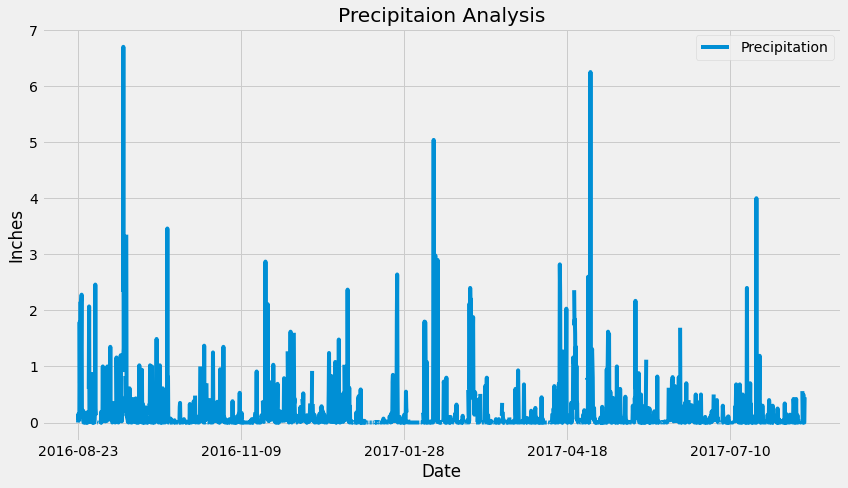

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
sorted_prcp_df.plot(title="Precipitaion Analysis", figsize=(12,7))
plt.legend(loc='best')
plt.savefig("Images/precipiation.png")
plt.ylabel("Inches")
plt.tight_layout()
plt.show()


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_recorded=[func.min(Measurement.tobs),
                func.max(Measurement.tobs),
               func.avg(Measurement.tobs)]

min_max_avg_temp = session.query(*temp_recorded).\
    filter(Measurement.station == "USC00519281").all()
min_max_avg_temp

[(54.0, 85.0, 71.66378066378067)]

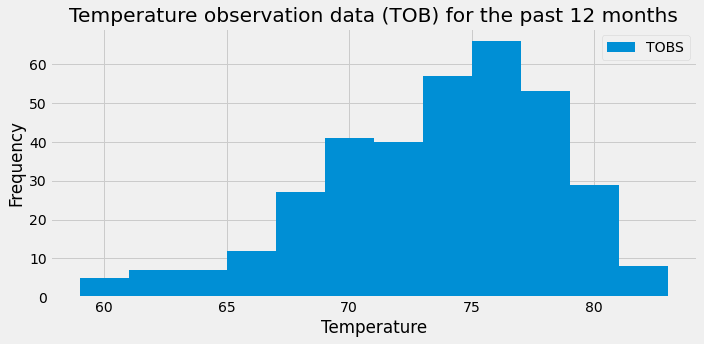

In [33]:
# Choose the station with the highest number of temperature observations.# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date>=oneyearago).\
    order_by(Measurement.date).all()
tobs_data_df = pd.DataFrame(tobs_data, columns=["TOBS"])
tobs_data_df

#plot the results as a histogram with 12 bins
tobs_data_df.plot.hist(bins=12, title="Temperature observation data (TOB) for the past 12 months", figsize=(10,5))
plt.xlabel("Temperature")
plt.legend(loc="best")
plt.savefig("Images/TOBs.png")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
dt_fmt = '%Y-%m-%d'
trip_start = "2017-9-20"
trip_end = "2017-9-30"

#to calculate the tmin, tavg, and tmax
str_yr_ago = (dt.datetime.strptime(trip_start, dt_fmt)- dt.timedelta(days=365)).strftime(dt_fmt)
end_yr_ago = (dt.datetime.strptime(trip_end, dt_fmt)- dt.timedelta(days=365)).strftime(dt_fmt)
trip = f"{str_yr_ago} to \n{end_yr_ago}"
print(trip)
temp_agg = calc_temps(str_yr_ago, end_yr_ago)
print(temp_agg)

2016-09-20 to 
2016-09-30
[(70.0, 77.94520547945206, 83.0)]


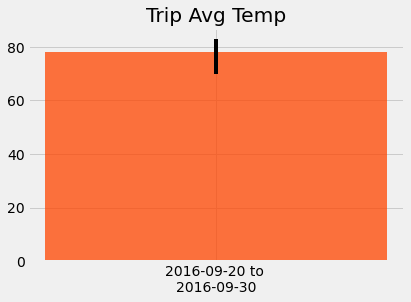

In [34]:
[tmin, tave, tmax] = temp_agg[0] # have to reference tuple inside list
minerr = tave-tmin 
maxerr = tmax - tave
errorbar=np.array([[minerr], [maxerr]])
plt.bar(trip, tave, yerr=errorbar, color='orangered', alpha=.75)
plt.title('Trip Avg Temp')
plt.savefig("Images/avrtemp.png")

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
str_yr_ago
end_yr_ago

# 1. calculate the total precipitation per weather station
#    a. sum the precipitation
#    b. join to station table to get name, lat,long,elevation
#    c. group by station, name, lat, long, elevation
# 2. sort by the station with most to least total precipitation

total_rainfall_func = func.sum(Measurement.prcp)

total_rainfall = session.query(Measurement.station, total_rainfall_func).\
    filter(Measurement.date >= str_yr_ago, Measurement.date<=end_yr_ago).\
    group_by(Measurement.station). \
    order_by(total_rainfall_func.desc()).all()

total_rainfall

[('USC00516128', 6.78),
 ('USC00519281', 2.79),
 ('USC00513117', 1.4700000000000002),
 ('USC00514830', 0.8700000000000001),
 ('USC00519523', 0.77),
 ('USC00519397', 0.1),
 ('USC00517948', 0.1)]

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip

# using the start and end date of the trip from above
end_dt = dt.datetime.strptime(trip_end, dt_fmt)
strt_dt = dt.datetime.strptime(trip_start, dt_fmt)
delta = end_dt - strt_dt

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
trip_dates = []
for i in range(delta.days + 1):
    curr_date = strt_dt + dt.timedelta(days=i)
    trip_dates.append(curr_date.strftime("%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
# push each tuple of calculations into a list called `normals`
normals = []
for date in trip_dates:
    # NOTE: unpack tuples so we have correct list of list shape 
    # for creating DataFrame below - if still packed in tuples, won't work
    normals.append(*daily_normals(date))

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
cols = ['tmax', 'tavg', 'tmax']
df = pd.DataFrame(np.array(normals),
                 columns=cols,
                 index=trip_dates)

df

,tmax,tavg,tmax
09-20,69.0,76.145833,83.0
09-21,67.0,76.448980,84.0
09-22,69.0,76.372549,84.0
09-23,67.0,75.826923,83.0
09-24,69.0,77.020000,85.0
09-25,69.0,76.148936,83.0
09-26,66.0,75.640000,85.0
09-27,68.0,75.640000,83.0
09-28,67.0,76.134615,84.0
09-29,68.0,75.978723,83.0


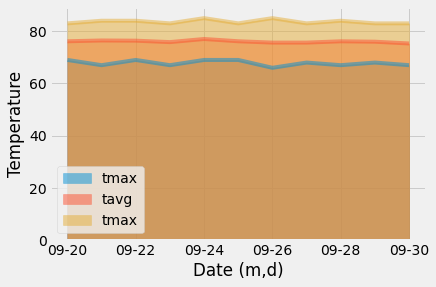

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df.plot.area(stacked=False)
ax.set_ylabel("Temperature")
ax.set_xlabel("Date (m,d)")
plt.savefig("Images/dailynormals.png")

In [29]:
# Close the session
session.close()